Merged shape: (125510, 139)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32640
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 128
[LightGBM] [Info] Start training from score -3.031359
[LightGBM] [Info] Start training from score -3.005783
[LightGBM] [Info] Start training from score -3.095553
[LightGBM] [Info] Start training from score -3.005783
[LightGBM] [Info] Start training from score -2.995732
[LightGBM] [Info] Start training from score -2.928074
[LightGBM] [Info] Start training from score -3.005783
[LightGBM] [Info] Start training from score -2.985782
[LightGBM] [Info] Start training from score -3.090043
[LightGBM] [Info] Start training from score -2.932757
[LightGBM] [Info] Start training from score -3.052303
[LightGBM] [Info] Start training from score -2.995732
[LightGBM] [Info] Start training f

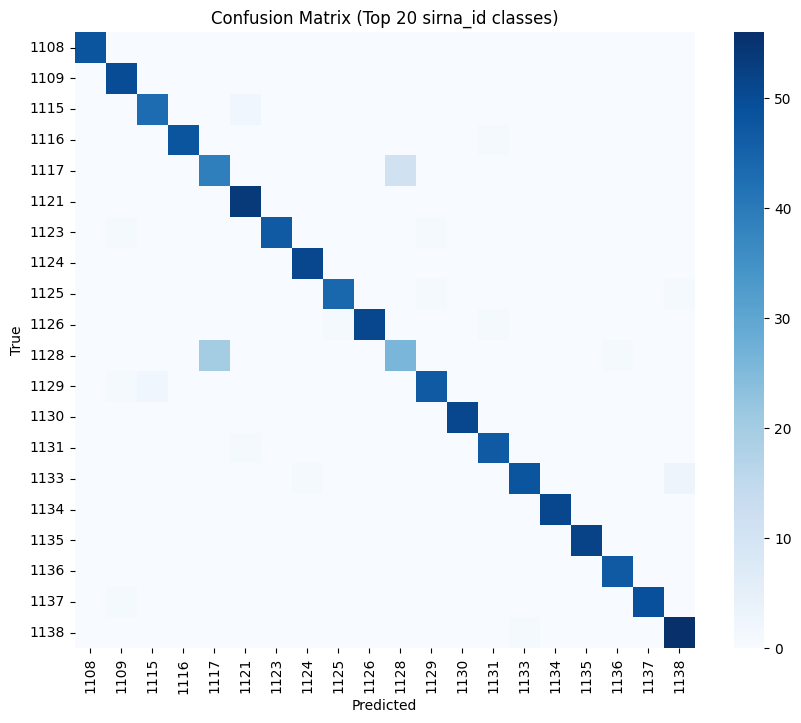

In [2]:
# 1. Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier

# 2. Load embeddings + metadata
embeddings_df = pd.read_csv(r"C:\Users\asimw\OneDrive\Desktop\BioStack Platform\data\embeddings.csv")
metadata_df = pd.read_csv(r"C:\Users\asimw\OneDrive\Desktop\BioStack Platform\data\metadata.csv")

# 3. Merge
merged_df = pd.merge(embeddings_df, metadata_df, on="site_id")
print("Merged shape:", merged_df.shape)

# 4. Filter to top 20 most common sirna_id labels
top_labels = merged_df["sirna_id"].value_counts().nlargest(20).index
filtered_df = merged_df[merged_df["sirna_id"].isin(top_labels)]

# 5. Subsample to 5000 rows
sampled_df = filtered_df.sample(n=5000, random_state=42)

# 6. Prepare features and labels
embedding_cols = [col for col in embeddings_df.columns if col != "site_id"]
X = sampled_df[embedding_cols].values

le = LabelEncoder()
y = le.fit_transform(sampled_df["sirna_id"])

# 7. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 8. LightGBM Classifier
lgb_clf = LGBMClassifier(
    objective="multiclass",
    num_class=len(np.unique(y)),
    num_leaves=64,
    learning_rate=0.1,
    n_estimators=50,
    random_state=42,
    n_jobs=1
)

lgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="multi_logloss"
)

# 9. Predict and evaluate
y_pred = lgb_clf.predict(X_test)

print("LightGBM Classifier Results:")
print(classification_report(y_test, y_pred))

# 10. Confusion matrix (all 20 classes)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (Top 20 sirna_id classes)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [4]:
from sklearn.manifold import TSNE

# Run t-SNE on full sampled data
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

# Predict on full sampled data
y_pred_full = lgb_clf.predict(X)
sampled_df["predicted"] = le.inverse_transform(y_pred_full)

# Add t-SNE coordinates
sampled_df["tsne_1"] = X_tsne[:, 0]
sampled_df["tsne_2"] = X_tsne[:, 1]

# Select columns for dashboard
dashboard_df = sampled_df[[
    "tsne_1", "tsne_2", "sirna_id", "predicted", "experiment", "plate", "well"
]]

# Save to dashboard folder (your actual path)
dashboard_df.to_csv(r"C:\Users\asimw\OneDrive\Desktop\BioStack Platform\dashboard\dashboard_data.csv", index=False)
print("✅ dashboard_data.csv saved to dashboard folder.")


✅ dashboard_data.csv saved to dashboard folder.
